# Setting working directory

## Load the Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change the workding dir to: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl'`

In [1]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl')

## Go to this place for original dataset: 

`'/content/drive/My Drive/Colab Notebooks/MachineLearningPractice/FinanceRiskControl/originalDataset'`

# Importing libraries

# Feature engineering

In [35]:
!pip install catboost

     |████████████████████████████████| 66.3MB 85kB/s 


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import sklearn
# import tqdm
warnings.filterwarnings('ignore')

In [4]:
data_train = pd.read_csv('originalDataset/train.csv')
data_test_a = pd.read_csv('originalDataset/testA.csv')

In [5]:
numerical_fea = list(data_train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(data_train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

## Fill the null

### Scheme A

No fillings

In [ ]:
# #按照平均数填充数值型特征
# data_train[numerical_fea] = data_train[numerical_fea].fillna(data_train[numerical_fea].median())
# data_test_a[numerical_fea] = data_test_a[numerical_fea].fillna(data_train[numerical_fea].median())
# #按照众数填充类别型特征
# data_train[category_fea] = data_train[category_fea].fillna(data_train[category_fea].mode())
# data_test_a[category_fea] = data_test_a[category_fea].fillna(data_train[category_fea].mode())

## Change time data

### Scheme A
`issueDate` the number of days after the earliest date; `employmentlength` changed into simple numbers; `earliesCreditLine` only take the year.

In [6]:
#转化成时间格式
for data in [data_train, data_test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days

In [7]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [data_train, data_test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [8]:
for data in [data_train, data_test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

## Change categorical data

In [9]:
# 部分类别特征
cate_features = ['homeOwnership', 'verificationStatus', 'initialListStatus', 'applicationType', 
                 'regionCode', 'employmentTitle', 'purpose', 'postCode', 'title', 
                 'grade', 'subGrade', ## I regard this as serial type. 
                 'policyCode', ## This is useless
                 ] ## n11, n12 is missing
for f in cate_features:
    print(f, '类型数：', data[f].nunique())

homeOwnership 类型数： 6
verificationStatus 类型数： 3
initialListStatus 类型数： 2
applicationType 类型数： 2
regionCode 类型数： 51
employmentTitle 类型数： 79282
purpose 类型数： 14
postCode 类型数： 889
title 类型数： 12058
grade 类型数： 7
subGrade 类型数： 35
policyCode 类型数： 1


### Scheme A

`grade, employmentTitle, postCode, title, subGrade`用的一般数字编码; 

`homeOwnership`, `verificationStatus`, `applicationType`, `initialListStatus`, `policyCode`用dummies编码.



In [10]:
# 类型数在2之上，又不是高维稀疏的,且纯分类特征
## 注意，这个方法跑了其实没什么卵用。不知道为什么。
## 就暂且不跑了得了。
# for data in [data_train, data_test_a]:
#     data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

## applicationType, initialListStatus, policyCode未处理。它们属于纯分类，但是类型数在2以下。
## 为什么不处理这样的特征呢？迷，迷，迷

In [11]:
for data in [data_train, data_test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})

In [12]:
data_train = pd.get_dummies(data_train, columns=['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"], drop_first=True)
data_test_a = pd.get_dummies(data_test_a, columns=['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"], drop_first=True)


In [13]:
#label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(data_train[col].astype(str).values) + list(data_test_a[col].astype(str).values))
    data_train[col] = le.transform(list(data_train[col].astype(str).values))
    data_test_a[col] = le.transform(list(data_test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|██████████| 4/4 [00:06<00:00,  1.68s/it]

Label Encoding 完成


## See abnormal data

In [ ]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

In [ ]:
data_train_cp = data_train.copy()
feaList = []
numList = []
for fea in numerical_fea:
    if fea in ['homeOwnership', 'verificationStatus', "applicationType", "initialListStatus", "policyCode"]:
        continue
    data_train_cp = find_outliers_by_3segama(data_train_cp,fea)
    valCount = data_train_cp[fea+'_outliers'].value_counts()
    abnormalRate = 1-valCount["正常值"] / len(data_train_cp)
    feaList.append(fea)
    numList.append(abnormalRate)
    # print(valCount, "\n") ## 获得正常值和异常值的数量
    # print(1-valCount["正常值"] / len(data_train_cp), "\n") ## 获得正常值和异常值的数量
    # print(data_train_cp.groupby(fea+'_outliers')['isDefault'].sum(), "\n") ## 获得异常值和正常值里面有多少个正例
    # print('*'*100)

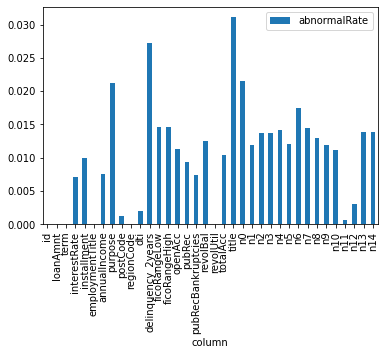

In [ ]:
tmpPd = pd.DataFrame({
    "column": feaList, 
    "abnormalRate": numList,
})
tmpPd.set_index(["column"], inplace=True)
tmpPd.plot(kind='bar')

就认为, 异常度0.015就作为阈值吧. 超过的, 就认为异常值较多. 

`n6, title, n0, purpose, delinquency_2years`

## Bin the data

In [ ]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
# for data in [data_train, data_test_a]:
#     data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)
#     data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))
#     data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

### Scheme A

Chi Bin: `n6, n0, purpose, delinquency_2years`. 为什么不处理`title`? 因为它的处理太费时间. 


In [14]:
import numpy as np
from scipy.stats import chi
import pandas as pd
from pandas import DataFrame,Series
import scipy

In [15]:
def chi3(arr):
    '''
    计算卡方值
    arr:频数统计表,二维numpy数组。
    '''
    assert(arr.ndim==2)
    #计算每行总频数
    R_N = arr.sum(axis=1)
    #每列总频数
    C_N = arr.sum(axis=0)
    #总频数
    N = arr.sum()
    # 计算期望频数 C_i * R_j / N。
    E = np.ones(arr.shape)* C_N / N
    E = (E.T * R_N).T
    square = (arr-E)**2 / E
    #期望频数为0时，做除数没有意义，不计入卡方值
    square[E==0] = 0
    #卡方值
    v = square.sum()
    return v

def chiMerge(df,col,target,max_groups=None,threshold=None):

    '''
    卡方分箱
    df: pandas dataframe数据集
    col: 需要分箱的变量名（数值型）
    target: 类标签
    max_groups: 最大分组数。
    threshold: 卡方阈值，如果未指定max_groups，默认使用置信度95%设置threshold。
    return: 包括各组的起始值的列表.
    '''

    freq_tab = pd.crosstab(df[col],df[target])

    #转成numpy数组用于计算。
    freq = freq_tab.values

    #初始分组切分点，每个变量值都是切分点。每组中只包含一个变量值.

    #分组区间是左闭右开的，如cutoffs = [1,2,3]，则表示区间 [1,2) , [2,3) ,[3,3+)。
    cutoffs = freq_tab.index.values

    #如果没有指定最大分组
    if max_groups is None:    
        #如果没有指定卡方阈值，就以95%的置信度（自由度为类数目-1）设定阈值。
        if threshold is None:
            #类数目
            cls_num = freq.shape[-1]
            threshold = chi2.isf(0.05,df= cls_num - 1)

    while True:
        minvalue = None
        minidx = None
        #从第1组开始，依次取两组计算卡方值，并判断是否小于当前最小的卡方
        for i in range(len(freq) - 1):
            v = chi3(freq[i:i+2])
            if minvalue is None or (minvalue > v): #小于当前最小卡方，更新最小值
                minvalue = v
                minidx = i

        #如果最小卡方值小于阈值，则合并最小卡方值的相邻两组，并继续循环
        if  (max_groups is not None and  max_groups< len(freq) ) or (threshold is not None and minvalue < threshold):
            #minidx后一行合并到minidx
            tmp  = freq[minidx] + freq[minidx+1]
            freq[minidx] = tmp
            #删除minidx后一行
            freq = np.delete(freq,minidx+1,0)
            #删除对应的切分点
            cutoffs = np.delete(cutoffs,minidx+1,0)

        else: #最小卡方值不小于阈值，停止合并。
            break
    return cutoffs

def value2group(x,cutoffs):

    '''
    将变量的值转换成相应的组。
    x: 需要转换到分组的值
    cutoffs: 各组的起始值。
    return: x对应的组，如group1。从group1开始。
    '''

    #切分点从小到大排序。
    cutoffs = sorted(cutoffs)
    num_groups = len(cutoffs)

    #异常情况：小于第一组的起始值。这里直接放到第一组。
    #异常值建议在分组之前先处理妥善。
    if x < cutoffs[0]:
        return 1 #'group1'

    for i in range(1,num_groups):
        if cutoffs[i-1] <= x < cutoffs[i]:
            return i # 'group{}'.format(i)

    #最后一组，也可能会包括一些非常大的异常值。
    return num_groups #'group{}'.format(num_groups)

def calWOE(df ,var ,target):

    '''
    计算WOE编码
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：编码字典
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    return gbri['woe'].to_dict()

def calIV(df,var,target):

    '''
    计算IV值
    param df：数据集pandas.dataframe
    param var：已分组的列名，无缺失值
    param target：响应变量（0,1）
    return：IV值
    '''
    eps = 0.000001  #避免除以0
    gbi = pd.crosstab(df[var],df[target]) + eps
    gb = df[target].value_counts() + eps
    gbri = gbi/gb
    gbri['woe'] = np.log(gbri[1]/gbri[0])
    gbri['iv'] = (gbri[1] - gbri[0])*gbri['woe']
    return gbri['iv'].sum()

In [16]:
for fea in ["n6", "n0", "purpose", "delinquency_2years"]: ## title 太久了, 不处理了. 
    print("for feature: {}...".format(fea))
    cutoffs = chiMerge(data_train, fea,'isDefault',max_groups=10)
    data_train[fea] = data_train[fea].apply(value2group,args=(cutoffs,))
    data_test_a[fea] = data_test_a[fea].apply(value2group,args=(cutoffs,))

for feature: n6...
for feature: n0...
for feature: purpose...
for feature: delinquency_2years...


## New feature generation

### Old school + No feature selection

In [17]:
for col in ['grade', 'subGrade']: 
    temp_dict = data_train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    data_train[col + '_target_mean'] = data_train[col].map(temp_dict)
    data_test_a[col + '_target_mean'] = data_test_a[col].map(temp_dict)

In [18]:
# 其他衍生变量 mean 和 std
for df in [data_train, data_test_a]:
    for item in ['n0','n1','n2','n3','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

## Generate into-model data

In [19]:
# 删除不需要的数据
for data in [data_train, data_test_a]:
    data.drop(['issueDate','id'], axis=1,inplace=True)

In [20]:
# "纵向用缺失值上面的值替换缺失值"
# data_train = data_train.fillna(axis=0,method='ffill')

In [21]:
features = [f for f in data_train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = data_train[features]
x_test = data_test_a[features]
y_train = data_train['isDefault']

# Save preprocessed data

In [ ]:
x_train.to_csv("preprocessedData/x_train-1128-OG.csv", index=False)
x_test.to_csv("preprocessedData/x_test-1128-OG.csv", index=False)
y_train.to_csv("preprocessedData/y_train-1128-OG.csv", index=False)

In [22]:
x_train.shape

(800000, 81)

# Some hands-on model fitting...

Load pretrained dataset if applicable. 

In [ ]:
x_train = pd.read_csv("preprocessedData/x_train-1128-OG.csv.csv")
x_test = pd.read_csv("preprocessedData/x_test-1128-OG.csv.csv")
y_train = pd.read_csv("preprocessedData/y_train-1128-OG.csv.csv")

In [23]:
x_train_part = x_train#.head(1000)
x_test_part = x_test#.head(1000)
y_train_part = y_train#.head(1000)

In [24]:
y_train_part.head()

0    1
1    0
2    0
3    0
4    0
Name: isDefault, dtype: int64

In [ ]:
x_train_part[y_train_part == 1].head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,verificationStatus,purpose,postCode,regionCode,dti,delinquency_2years,ficoRangeLow,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,initialListStatus,applicationType,earliesCreditLine,title,policyCode,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,grade_target_mean,subGrade_target_mean,grade_to_mean_n0,grade_to_std_n0,grade_to_mean_n1,grade_to_std_n1,grade_to_mean_n2,grade_to_std_n2,grade_to_mean_n3,grade_to_std_n3,grade_to_mean_n4,grade_to_std_n4,grade_to_mean_n5,grade_to_std_n5,grade_to_mean_n6,grade_to_std_n6,grade_to_mean_n7,grade_to_std_n7,grade_to_mean_n8,grade_to_std_n8,grade_to_mean_n9,grade_to_std_n9,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,5,21,192025,2.0,2,110000.0,2,1,43,32,17.05,0.0,730.0,734.0,7.0,0.0,0.0,24178.0,48.9,27.0,0,0,2001,1,1.0,0.0,2.0,2.0,2.0,4.0,9.0,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2587,0.384291,0.376903,1.853364,3.848126,1.845529,3.915247,1.915171,3.862588,1.915171,3.862588,1.850437,3.842205,1.856007,3.905387,1.836213,3.873036,1.811571,3.935826,1.822148,3.905928,1.911723,3.864778,1.820574,3.980333,1.821304,3.863294,1.821980,3.863687,1.829339,3.856340,1.845480,3.899647
8,12000.0,3,12.99,404.27,3,11,77517,5.0,2,60000.0,1,0,770,13,19.22,0.0,690.0,694.0,15.0,0.0,0.0,27176.0,46.0,21.0,1,0,1994,0,1.0,0.0,7.0,13.0,13.0,7.0,7.0,2.0,13.0,17.0,11.0,15.0,0.0,0.0,0.0,6.0,3257,0.225020,0.206892,1.112018,2.308875,1.057123,2.289009,0.988706,2.257254,0.988706,2.257254,1.114016,2.308565,1.123599,2.291216,1.091022,2.381790,1.096517,2.299232,1.108737,2.326348,1.008001,2.270976,1.098670,2.287395,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,0.913091,2.229995
17,5500.0,3,10.99,180.04,2,8,281585,0.0,1,50000.0,1,4,512,8,17.14,0.0,695.0,699.0,5.0,0.0,0.0,5463.0,76.9,10.0,1,0,1995,26200,1.0,0.0,3.0,3.0,3.0,3.0,5.0,2.0,4.0,7.0,3.0,5.0,0.0,0.0,0.0,0.0,2891,0.132992,0.148639,0.741345,1.539250,0.742960,1.547582,0.754308,1.561191,0.754308,1.561191,0.719608,1.576699,0.713589,1.562627,0.727348,1.587860,0.724628,1.574330,0.705691,1.577230,0.753453,1.562878,0.722008,1.615902,0.728522,1.545317,0.728792,1.545475,0.731736,1.542536,0.838771,1.707013
18,6000.0,3,21.00,226.06,5,21,194567,10.0,1,40000.0,0,3,47,8,28.95,3.0,660.0,664.0,6.0,0.0,0.0,6804.0,84.0,29.0,0,0,2001,34492,1.0,1.0,2.0,4.0,4.0,2.0,13.0,7.0,4.0,22.0,4.0,6.0,0.0,0.0,1.0,0.0,2010,0.384291,0.376903,1.726247,3.938603,1.845529,3.915247,1.856579,3.927183,1.856579,3.927183,1.770871,3.929524,1.896010,3.873309,1.885900,3.783668,1.811571,3.935826,1.854329,3.848955,1.855358,3.927522,1.809756,4.015371,1.821304,3.863294,1.821980,3.863687,1.692122,4.021286,2.096926,4.267533
23,20000.0,3,14.08,684.33,3,12,241933,4.0,1,47500.0,1,9,142,21,24.36,0.0,665.0,669.0,7.0,0.0,0.0,19497.0,53.1,19.0,0,0,2000,2,1.0,0.0,4.0,4.0,4.0,4.0,7.0,9.0,6.0,10.0,4.0,7.0,0.0,0.0,0.0,1.0,3867,0.225020,0.224576,1.112018,2.308875,1.092956,2.343663,1.113947,2.356310,1.113947,2.356310,1.110262,2.305323,1.123599,2.291216,1.098202,2.301539,1.092694,2.363814,1.089815,2.350626,1.113215,2.356513,1.092345,2.388200,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,1.173155,2.461025


In [ ]:
y_train_part[y_train_part == 0]

1         0
2         0
3         0
4         0
5         0
         ..
799993    0
799995    0
799996    0
799998    0
799999    0
Name: isDefault, Length: 640390, dtype: int64

In [ ]:
y_train_part[y_train_part == 1]

0         1
8         1
17        1
18        1
23        1
         ..
799970    1
799975    1
799980    1
799994    1
799997    1
Name: isDefault, Length: 159610, dtype: int64

## Balanced label

In [25]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    train_x_positive = train_x[train_y == 1]
    train_y_positive = train_y[train_y == 1]

    train_x_negative = train_x[train_y == 0]
    train_y_negative = train_y[train_y == 0]
    
    round_count = 0
###==========================================================================================================
    # def mergeAndShuffle(train_index_positive, train_index_negative):
    #     train_index = np.append(train_index_positive, train_index_negative)
    #     train_index = sklearn.utils.shuffle(train_index)
    #     return train_index

    # for (train_index_positive, valid_index_positive), (train_index_negative, valid_index_negative) in zip(kf.split(train_x_positive, train_y_positive), kf.split(train_x_negative, train_y_negative)):
    #     round_count += 1
    #     print('************************************ {} ************************************'.format(round_count))
    #     train_index = mergeAndShuffle(train_index_positive, train_index_negative)
    #     valid_index = mergeAndShuffle(valid_index_positive, valid_index_negative)
    #     print(train_index_positive, train_index_negative)
    #     print(valid_index_positive, valid_index_negative)
    #     trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]
###==========================================================================================================
    def concatAndShuffle(trn_x_p, trn_x_n, trn_y_p, trn_y_n):
        trn_x = pd.concat([trn_x_p, trn_x_n])
        trn_y = pd.concat([trn_y_p, trn_y_n])
        trn_x["isDefault"] = trn_y
        trn_x = sklearn.utils.shuffle(trn_x)
        trn_y = trn_x["isDefault"]
        trn_x.drop("isDefault", axis = 1, inplace = True)
        return trn_x, trn_y

    for (train_index_positive, valid_index_positive), (train_index_negative, valid_index_negative) in zip(kf.split(train_x_positive, train_y_positive), kf.split(train_x_negative, train_y_negative)):
        round_count += 1
        print('************************************ {} ************************************'.format(round_count))
        trn_x_p, trn_y_p, val_x_p, val_y_p = train_x_positive.iloc[train_index_positive], train_y_positive.iloc[train_index_positive], train_x_positive.iloc[valid_index_positive], train_y_positive.iloc[valid_index_positive]
        trn_x_n, trn_y_n, val_x_n, val_y_n = train_x_negative.iloc[train_index_negative], train_y_negative.iloc[train_index_negative], train_x_negative.iloc[valid_index_negative], train_y_negative.iloc[valid_index_negative]

        trn_x, trn_y = concatAndShuffle(trn_x_p, trn_x_n, trn_y_p, trn_y_n)
        val_x, val_y = concatAndShuffle(val_x_p, val_x_n, val_y_p, val_y_n)
###==========================================================================================================
        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 50,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        # test += test_pred
        ##
        # train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return test # / kf.n_splits    train, 

In [26]:
def lgb_model(x_train, y_train, x_test):
    lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")# lgb_train, 
    return lgb_test# lgb_train, 

def xgb_model(x_train, y_train, x_test):
    xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")# xgb_train, 
    return xgb_test# xgb_train, 

def cat_model(x_train, y_train, x_test):
    cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")# cat_train, 
    return cat_test# cat_train, 

In [37]:
cat_test = cat_model(x_train_part, y_train_part, x_test_part)# xgb_train, 

************************************ 1 ************************************
0:	learn: 0.3981554	test: 0.3981501	best: 0.3981501 (0)	total: 135ms	remaining: 44m 51s
500:	learn: 0.3754183	test: 0.3760795	best: 0.3760795 (500)	total: 38.7s	remaining: 25m 5s
1000:	learn: 0.3739644	test: 0.3754670	best: 0.3754670 (1000)	total: 1m 14s	remaining: 23m 31s
1500:	learn: 0.3729646	test: 0.3752025	best: 0.3752025 (1500)	total: 1m 49s	remaining: 22m 27s
2000:	learn: 0.3720840	test: 0.3750524	best: 0.3750517 (1999)	total: 2m 24s	remaining: 21m 40s
2500:	learn: 0.3712595	test: 0.3749532	best: 0.3749532 (2500)	total: 2m 59s	remaining: 20m 55s
3000:	learn: 0.3705189	test: 0.3748934	best: 0.3748934 (3000)	total: 3m 34s	remaining: 20m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3748632009
bestIteration = 3165

Shrink model to first 3166 iterations.
[0.7366684756926252]
************************************ 2 ************************************
0:	learn: 0.3981545	test: 0.39816

In [38]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [39]:
testA_result_pred["isDefault"] = lgb_test
testA_result_pred.to_csv("submissionResults/xgboost-1128-cat-1-7357.csv", index=False)

## Regular

In [ ]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 50,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        # test += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)
    return train, test # / kf.n_splits

In [ ]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

In [ ]:
xgb_train, xgb_test = xgb_model_weighted(x_train, y_train, x_test)

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
testA_result_pred["isDefault"] = xgb_test
testA_result_pred.to_csv("submissionResults/xgboost-1109-3.7-prop-7365.csv", index=False)

## Weighted

In [ ]:
def cv_model_weighted(clf, train_x, train_y, test_x, clf_name):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = [] # np.zeros(test_x.shape[0])
    sumTest = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test.append(test_pred)
        sumTest += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    print("the cv_scores: ", cv_scores)
    sum(cv_scores)
    props = [i / sum(cv_scores) for i in cv_scores]
    print("the proportion of cv scores: ", props)
    print("the sum of proportion of cv scores", sum(props))
    prop_test = np.zeros(test_x.shape[0])
    for test_score, prop in zip(test, props):
        prop_test += test_score * prop

    return train, prop_test #, sumTest / kf.n_splits

In [ ]:
def lgb_model_weighted(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model_weighted(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model_weighted(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model_weighted(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model_weighted(x_train, y_train, x_test):
    cat_train, cat_test = cv_model_weighted(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

In [ ]:
xgb_train, xgb_test = xgb_model_weighted(x_train, y_train, x_test)

************************************ 1 ************************************
[0]	train-auc:0.695464	eval-auc:0.696327
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.731149	eval-auc:0.728776
[400]	train-auc:0.739646	eval-auc:0.733051
[600]	train-auc:0.744984	eval-auc:0.734734
[800]	train-auc:0.749163	eval-auc:0.735674
[1000]	train-auc:0.752928	eval-auc:0.736365
[1200]	train-auc:0.756385	eval-auc:0.736759
[1400]	train-auc:0.759639	eval-auc:0.737057
[1600]	train-auc:0.762694	eval-auc:0.737201
[1800]	train-auc:0.76569	eval-auc:0.737356
[2000]	train-auc:0.768603	eval-auc:0.73738
[2200]	train-auc:0.771428	eval-auc:0.737388
Stopping. Best iteration:
[2120]	train-auc:0.770308	eval-auc:0.737444

[0.7374438644326278]
************************************ 2 ************************************
[0]	train-auc:0.696544	eval-auc:0.693111
Multiple eval metrics have been passed: 'eval-auc' wil

In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred = testA_result.copy()

In [ ]:
testA_result_pred["isDefault"] = xgb_test
testA_result_pred.to_csv("submissionResults/xgboost-1109-3.7-prop-7365.csv", index=False)

## Return scores and test rsts

In [ ]:
def cv_model_scoreAndTest(clf, train_x, train_y, test_x, clf_name):
    folds = 15
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = [] # np.zeros(test_x.shape[0])
    sumTest = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': "gpu_hist", #'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test.append(test_pred)
        sumTest += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    print("the cv_scores: ", cv_scores)
    # sum(cv_scores)
    # props = [i / sum(cv_scores) for i in cv_scores]
    # print("the proportion of cv scores: ", props)
    # print("the sum of proportion of cv scores", sum(props))
    # prop_test = np.zeros(test_x.shape[0])
    # for test_score, prop in zip(test, props):
    #     prop_test += test_score * prop

    return train, cv_scores, test # train, prop_test #, sumTest / kf.n_splits

In [ ]:
def lgb_model_scoreAndTest(x_train, y_train, x_test):
    lgb_train, lgb_cvs, lgb_test = cv_model_scoreAndTest(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_cvs, lgb_test

def xgb_model_scoreAndTest(x_train, y_train, x_test):
    xgb_train, xgb_cvs, xgb_test = cv_model_scoreAndTest(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_cvs, xgb_test

def cat_model_scoreAndTest(x_train, y_train, x_test):
    cat_train, cat_cvs, cat_test = cv_model_scoreAndTest(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_cvs, cat_test 

In [ ]:
def generateFinalTestRst(cvs, test):
    cv_scores = cvs
    sum(cv_scores)
    props = [i / sum(cv_scores) for i in cv_scores]
    print("avg cv scores: ", sum(cv_scores) / len(cv_scores))
    print("the proportion of cv scores: ", props)
    print("the sum of proportion of cv scores", sum(props))
    prop_test = np.zeros(test[0].shape[0])
    avg_test = np.zeros(test[0].shape[0])
    for test_score, prop in zip(test, props):
        prop_test += test_score * prop
        avg_test += test_score / len(test)
    return prop_test, avg_test

In [ ]:
xgb_train, xgb_cvs, xgb_test = xgb_model_scoreAndTest(x_train, y_train, x_test)

************************************ 1 ************************************
[0]	train-auc:0.695665	eval-auc:0.701166
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.730929	eval-auc:0.73249
[400]	train-auc:0.738848	eval-auc:0.73645
[600]	train-auc:0.743732	eval-auc:0.73809
[800]	train-auc:0.747597	eval-auc:0.739014
[1000]	train-auc:0.750913	eval-auc:0.739616
[1200]	train-auc:0.75414	eval-auc:0.740078
[1400]	train-auc:0.75702	eval-auc:0.740242
[1600]	train-auc:0.759697	eval-auc:0.740442
[1800]	train-auc:0.762375	eval-auc:0.740468
[2000]	train-auc:0.765052	eval-auc:0.74067
[2200]	train-auc:0.767524	eval-auc:0.740692
[2400]	train-auc:0.769936	eval-auc:0.740642
Stopping. Best iteration:
[2277]	train-auc:0.768391	eval-auc:0.740729

[0.740729445994099]
************************************ 2 ************************************
[0]	train-auc:0.695878	eval-auc:0.695093
Multiple eval m

In [ ]:
prop_test, avg_test = generateFinalTestRst(xgb_cvs, xgb_test)

avg cv scores:  0.7371885322458013
the proportion of cv scores:  [0.066986884502712, 0.06681510593480901, 0.06647477741502507, 0.06628546830641231, 0.06650623651252603, 0.066453655758242, 0.0667246612100432, 0.06666861014177988, 0.0668943522588038, 0.06675120094874588, 0.06651977731546921, 0.06704492040843343, 0.06644259708067314, 0.0667265486845686, 0.06670520352175618]
the sum of proportion of cv scores 0.9999999999999998


In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
testA_result_pred_prop = testA_result.copy()
testA_result_pred_avg = testA_result.copy()

In [ ]:
testA_result_pred_prop["isDefault"] = prop_test
testA_result_pred_prop.to_csv("submissionResults/xgboost-1110-3.7-prop-15Fold-7371.csv", index=False)

In [ ]:
testA_result_pred_avg["isDefault"] = avg_test
testA_result_pred_avg.to_csv("submissionResults/xgboost-1110-3.7-avg-15Fold-7371.csv", index=False)

## Change parameters

In [ ]:
def cv_model_scoreAndTest_paraChanged(clf, train_x, train_y, test_x, clf_name, params):
    folds = 5
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = [] # np.zeros(test_x.shape[0])
    sumTest = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            # params = {
            #     'boosting_type': 'gbdt',
            #     'objective': 'binary',
            #     'metric': 'auc',
            #     'min_child_weight': 5,
            #     'num_leaves': 2 ** 5,
            #     'lambda_l2': 10,
            #     'feature_fraction': 0.8,
            #     'bagging_fraction': 0.8,
            #     'bagging_freq': 4,
            #     'learning_rate': 0.1,
            #     'seed': 2020,
            #     'nthread': 28,
            #     'n_jobs':24,
            #     'silent': True,
            #     'verbose': -1,
            # }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            # params = {
            #     'booster': 'gbtree',
            #     'objective': 'binary:logistic',
            #     'eval_metric': 'auc',
            #     'gamma': 2, # 1,
            #     'min_child_weight': 0.5046, #0, #1.5,
            #     'max_depth': 10, #7, #5,
            #     'lambda': 20, # 10,
            #     'subsample': 0.9768, # 0.92, #0.7,
            #     'colsample_bytree': 0.9771, # 0.8, #0.7,
            #     'colsample_bylevel': 0.8972, # 0.9, #0.7,
            #     'eta': 0.0001, # 0.06, #0.04,
            #     'tree_method': "gpu_hist", #'exact',
            #     'seed': 2020,
            #     'nthread': 36,
            #     "silent": True,
            # }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            # https://stackoverflow.com/questions/55579610/xgboost-attributeerror-dataframe-object-has-no-attribute-feature-names
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(xgb.DMatrix(test_x) , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            # params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
            #           'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        ## 下面这个test，可以考虑像如下这样进行，或者是求平均亦可。
        # test += test_pred / kf.n_splits ## Minke's invention, no basis or reference.
        test.append(test_pred)
        sumTest += test_pred
        ##
        train[valid_index] = val_pred
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    print("what is kf.n_splits?", kf.n_splits)

    print("the cv_scores: ", cv_scores)

    return train, cv_scores, test 

In [ ]:
# def lgb_model_scoreAndTest_paraChanged(x_train, y_train, x_test):
#     lgb_train, lgb_cvs, lgb_test = cv_model_scoreAndTest_paraChanged(lgb, x_train, y_train, x_test, "lgb")
#     return lgb_train, lgb_cvs, lgb_test

# def xgb_model_scoreAndTest_paraChanged(x_train, y_train, x_test):
#     xgb_train, xgb_cvs, xgb_test = cv_model_scoreAndTest_paraChanged(xgb, x_train, y_train, x_test, "xgb")
#     return xgb_train, xgb_cvs, xgb_test

# def cat_model_scoreAndTest_paraChanged(x_train, y_train, x_test):
#     cat_train, cat_cvs, cat_test = cv_model_scoreAndTest_paraChanged(CatBoostRegressor, x_train, y_train, x_test, "cat")
#     return cat_train, cat_cvs, cat_test 

In [ ]:
def generateFinalTestRst(cvs, test):
    cv_scores = cvs
    sum(cv_scores)
    props = [i / sum(cv_scores) for i in cv_scores]
    print("avg cv scores: ", sum(cv_scores) / len(cv_scores))
    print("the proportion of cv scores: ", props)
    print("the sum of proportion of cv scores", sum(props))
    prop_test = np.zeros(test[0].shape[0])
    avg_test = np.zeros(test[0].shape[0])
    for test_score, prop in zip(test, props):
        prop_test += test_score * prop
        avg_test += test_score / len(test)
    return prop_test, avg_test

In [ ]:
xgb_train, xgb_cvs, xgb_test = cv_model_scoreAndTest_paraChanged(
    xgb, x_train, y_train, x_test, "xgb", 
    {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'gamma': 1,
        'min_child_weight': 0, #1.5,
        'max_depth': 7, #5,
        'lambda': 10,
        'subsample': 0.92, #0.7,
        'colsample_bytree': 0.8, #0.7,
        'colsample_bylevel': 0.9, #0.7,
        'eta': 0.06, #0.04,
        'tree_method': "gpu_hist", #'exact',
        'seed': 2020,
        'nthread': 36,
        "silent": True,
    }, 
)

************************************ 1 ************************************
[0]	train-auc:0.703189	eval-auc:0.701729
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.755353	eval-auc:0.734433
[400]	train-auc:0.773971	eval-auc:0.736497
[600]	train-auc:0.788326	eval-auc:0.73683
[800]	train-auc:0.801306	eval-auc:0.736931
Stopping. Best iteration:
[728]	train-auc:0.796883	eval-auc:0.737024

[0.7370241247368534]
************************************ 2 ************************************
[0]	train-auc:0.704231	eval-auc:0.697082
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.756459	eval-auc:0.730702
[400]	train-auc:0.774747	eval-auc:0.732742
[600]	train-auc:0.789555	eval-auc:0.733445
[800]	train-auc:0.802347	eval-auc:0.733675
[1000]	train-auc:0.814594	eval-auc:0.733525
Stop

In [ ]:
prop_test, avg_test = generateFinalTestRst(xgb_cvs, xgb_test)

avg cv scores:  0.7357959329772146
the proportion of cv scores:  [0.20033384032300078, 0.19942553970420232, 0.20028786442873053, 0.20010798151430056, 0.19984477402976594]
the sum of proportion of cv scores 1.0000000000000002


In [ ]:
testA_result = pd.read_csv('originalDataset/sample_submit.csv')
# testA_result_pred_prop = testA_result.copy()
testA_result_pred_avg = testA_result.copy()

In [ ]:
# testA_result_pred_prop["isDefault"] = prop_test
# testA_result_pred_prop.to_csv("submissionResults/xgboost-1109-3.7-prop-1-7365.csv", index=False)

In [ ]:
testA_result_pred_avg["isDefault"] = avg_test
testA_result_pred_avg.to_csv("submissionResults/xgboost-1110-3.7-avg-hp1-7357.csv", index=False)